<a href="https://colab.research.google.com/github/task-master98/RadioUNet/blob/devel/RadioUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radio U Nets: Estimating Path Loss Functions

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/RadioUNet/RadioMapSeer.zip > /dev/null

In [3]:
import sys
sys.path.insert(0, '/content')
import os

In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import warnings
warnings.filterwarnings("ignore")


dir_gainDPM="/content/gain/DPM/"
dir_gainDPMcars="/content/gain/carsDPM/"
dir_gainIRT2="/content/gain/IRT2/"
dir_gainIRT2cars="/content/gain/carsIRT2/"
dir_buildings="/content/png/"

                    

class RadioUNet_c(Dataset):
    """RadioMapSeer Loader for accurate buildings and no measurements (RadioUNet_c)"""
    def __init__(self,maps_inds=np.zeros(1), phase="train",
                 ind1=0,ind2=0, 
                 dir_dataset=r"/content/",
                 numTx=80,                  
                 thresh=0.2,
                 simulation="DPM",
                 carsSimul="no",
                 carsInput="no",
                 IRT2maxW=1,
                 cityMap="complete",
                 missing=1,
                 transform= transforms.ToTensor()):
        """
        Args:
            maps_inds: optional shuffled sequence of the maps. Leave it as maps_inds=0 (default) for the standart split.
            phase:"train", "val", "test", "custom". If "train", "val" or "test", uses a standard split.
                  "custom" means that the loader will read maps ind1 to ind2 from the list maps_inds.
            ind1,ind2: First and last indices from maps_inds to define the maps of the loader, in case phase="custom". 
            dir_dataset: directory of the RadioMapSeer dataset.
            numTx: Number of transmitters per map. Default and maximal value of numTx = 80.                 
            thresh: Pathlos threshold between 0 and 1. Default is the noise floor 0.2.
            simulation:"DPM", "IRT2", "rand". Default= "DPM"
            carsSimul:"no", "yes". Use simulation with or without cars. Default="no".
            carsInput:"no", "yes". Take inputs with or without cars channel. Default="no".
            IRT2maxW: in case of "rand" simulation, the maximal weight IRT2 can take. Default=1.
            cityMap: "complete", "missing", "rand". Use the full city, or input map with missing buildings "rand" means that there is 
                      a random number of missing buildings.
            missing: 1 to 4. in case of input map with missing buildings, and not "rand", the number of missing buildings. Default=1.
            transform: Transform to apply on the images of the loader.  Default= transforms.ToTensor())
                 
        Output:
            inputs: The RadioUNet inputs.  
            image_gain
            
        """
        

        
        #self.phase=phase
                
        if maps_inds.size==1:
            self.maps_inds=np.arange(0,700,1,dtype=np.int16)
            #Determenistic "random" shuffle of the maps:
            np.random.seed(42)
            np.random.shuffle(self.maps_inds)
        else:
            self.maps_inds=maps_inds

        """
        Standard splits
        
        Sr No.|| Train || Test || Validation ||
        ***************************************
        1     || 500   || 100  || 100        ||
        ***************************************
        2     || 400   || 100  || 200        ||
        ***************************************
        
        
        """
        if phase=="train":
            self.ind1=0
            self.ind2=500
        elif phase=="val":
            self.ind1=501
            self.ind2=600
        elif phase=="test":
            self.ind1=601
            self.ind2=699
        else: # custom range
            self.ind1=ind1
            self.ind2=ind2
            
        self.dir_dataset = dir_dataset
        self.numTx=  numTx                
        self.thresh=thresh
        
        self.simulation=simulation
        self.carsSimul=carsSimul
        self.carsInput=carsInput
        if simulation=="DPM" :
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/DPM/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsDPM/"
        elif simulation=="IRT2":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT2/"
        elif  simulation=="rand":
            if carsSimul=="no":
                self.dir_gainDPM=self.dir_dataset+"gain/DPM/"
                self.dir_gainIRT2=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gainDPM=self.dir_dataset+"gain/carsDPM/"
                self.dir_gainIRT2=self.dir_dataset+"gain/carsIRT2/"
        
        self.IRT2maxW=IRT2maxW
        
        self.cityMap=cityMap
        self.missing=missing
        if cityMap=="complete":
            self.dir_buildings=self.dir_dataset+"png/buildings_complete/"
        else:
            self.dir_buildings = self.dir_dataset+"png/buildings_missing" # a random index will be concatenated in the code
        #else:  #missing==number
        #    self.dir_buildings = self.dir_dataset+ "png/buildings_missing"+str(missing)+"/"
            
              
        self.transform= transform
        
        self.dir_Tx = self.dir_dataset+ "png/antennas/" 
        #later check if reading the JSON file and creating antenna images on the fly is faster
        if carsInput!="no":
            self.dir_cars = self.dir_dataset+ "png/cars/" 
        
        self.height = 256
        self.width = 256

        
    def __len__(self):
        return (self.ind2-self.ind1+1)*self.numTx
    
    def __getitem__(self, idx):
        
        idxr=np.floor(idx/self.numTx).astype(int)
        idxc=idx-idxr*self.numTx 
        dataset_map_ind=self.maps_inds[idxr+self.ind1]+1
        #names of files that depend only on the map:
        name1 = str(dataset_map_ind) + ".png"
        #names of files that depend on the map and the Tx:
        name2 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        
        #Load buildings:
        if self.cityMap == "complete":
            img_name_buildings = os.path.join(self.dir_buildings, name1)
        else:
            if self.cityMap == "rand":
                self.missing=np.random.randint(low=1, high=5)
            version=np.random.randint(low=1, high=7)
            img_name_buildings = os.path.join(self.dir_buildings+str(self.missing)+"/"+str(version)+"/", name1)
            str(self.missing)
        image_buildings = np.asarray(io.imread(img_name_buildings))   
        
        #Load Tx (transmitter):
        img_name_Tx = os.path.join(self.dir_Tx, name2)
        image_Tx = np.asarray(io.imread(img_name_Tx))
        
        #Load radio map:
        if self.simulation!="rand":
            img_name_gain = os.path.join(self.dir_gain, name2)  
            image_gain = np.expand_dims(np.asarray(io.imread(img_name_gain)),axis=2)/255
        else: #random weighted average of DPM and IRT2
            img_name_gainDPM = os.path.join(self.dir_gainDPM, name2) 
            img_name_gainIRT2 = os.path.join(self.dir_gainIRT2, name2) 
            #image_gainDPM = np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/255
            #image_gainIRT2 = np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/255
            w=np.random.uniform(0,self.IRT2maxW) # IRT2 weight of random average
            image_gain= w*np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/256  \
                        + (1-w)*np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/256
        
        #pathloss threshold transform
        if self.thresh>0:
            mask = image_gain < self.thresh
            image_gain[mask]=self.thresh
            image_gain=image_gain-self.thresh*np.ones(np.shape(image_gain))
            image_gain=image_gain/(1-self.thresh)
                 
        
        #inputs to radioUNet
        if self.carsInput=="no":
            inputs=np.stack([image_buildings, image_Tx], axis=2)        
            #The fact that the buildings and antenna are normalized  256 and not 1 promotes convergence, 
            #so we can use the same learning rate as RadioUNets
        else: #cars
            #Normalization, so all settings can have the same learning rate
            image_buildings=image_buildings/256
            image_Tx=image_Tx/256
            img_name_cars = os.path.join(self.dir_cars, name1)
            image_cars = np.asarray(io.imread(img_name_cars))/256
            inputs=np.stack([image_buildings, image_Tx, image_cars], axis=2)
            #note that ToTensor moves the channel from the last asix to the first!

        
        if self.transform:
            inputs = self.transform(inputs).type(torch.float32)
            image_gain = self.transform(image_gain).type(torch.float32)
            #note that ToTensor moves the channel from the last asix to the first!


        return [inputs, image_gain]
    
    
    
    

class RadioUNet_c_sprseIRT4(Dataset):
    """RadioMapSeer Loader for accurate buildings and no measurements (RadioUNet_c)"""
    def __init__(self,maps_inds=np.zeros(1), phase="train",
                 ind1=0,ind2=0, 
                 dir_dataset="RadioMapSeer/",
                 numTx=2,                  
                 thresh=0.2,
                 simulation="IRT4",
                 carsSimul="no",
                 carsInput="no",
                 cityMap="complete",
                 missing=1,
                 num_samples=300,
                 transform= transforms.ToTensor()):
        """
        Args:
            maps_inds: optional shuffled sequence of the maps. Leave it as maps_inds=0 (default) for the standart split.
            phase:"train", "val", "test", "custom". If "train", "val" or "test", uses a standard split.
                  "custom" means that the loader will read maps ind1 to ind2 from the list maps_inds.
            ind1,ind2: First and last indices from maps_inds to define the maps of the loader, in case phase="custom". 
            dir_dataset: directory of the RadioMapSeer dataset.
            numTx: Number of transmitters per map. Default = 2. Note that IRT4 works only with numTx<=2.                
            thresh: Pathlos threshold between 0 and 1. Defaoult is the noise floor 0.2.
            simulation: default="IRT4", with an option to "DPM", "IRT2".
            carsSimul:"no", "yes". Use simulation with or without cars. Default="no".
            carsInput:"no", "yes". Take inputs with or without cars channel. Default="no".
            cityMap: "complete", "missing", "rand". Use the full city, or input map with missing buildings "rand" means that there is 
                      a random number of missing buildings.
            missing: 1 to 4. in case of input map with missing buildings, and not "rand", the number of missing buildings. Default=1.
            num_samples: number of samples in the sparse IRT4 radio map. Default=300.
            transform: Transform to apply on the images of the loader.  Default= transforms.ToTensor())
            
        Output:
            
        """
        if maps_inds.size==1:
            self.maps_inds=np.arange(0,700,1,dtype=np.int16)
            #Determenistic "random" shuffle of the maps:
            np.random.seed(42)
            np.random.shuffle(self.maps_inds)
        else:
            self.maps_inds=maps_inds
            
        if phase=="train":
            self.ind1=0
            self.ind2=500
        elif phase=="val":
            self.ind1=501
            self.ind2=600
        elif phase=="test":
            self.ind1=601
            self.ind2=699
        else: # custom range
            self.ind1=ind1
            self.ind2=ind2
            
        self.dir_dataset = dir_dataset
        self.numTx=  numTx                
        self.thresh=thresh
        
        self.simulation=simulation
        self.carsSimul=carsSimul
        self.carsInput=carsInput
        if simulation=="IRT4":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT4/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT4/"
        
        elif simulation=="DPM" :
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/DPM/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsDPM/"
        elif simulation=="IRT2":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT2/"  
        
        
        self.cityMap=cityMap
        self.missing=missing
        if cityMap=="complete":
            self.dir_buildings=self.dir_dataset+"png/buildings_complete/"
        else:
            self.dir_buildings = self.dir_dataset+"png/buildings_missing" # a random index will be concatenated in the code
        #else:  #missing==number
        #    self.dir_buildings = self.dir_dataset+ "png/buildings_missing"+str(missing)+"/"
            
              
        self.transform= transform
        
        self.num_samples=num_samples
        
        self.dir_Tx = self.dir_dataset+ "png/antennas/" 
        #later check if reading the JSON file and creating antenna images on the fly is faster
        if carsInput!="no":
            self.dir_cars = self.dir_dataset+ "png/cars/" 
        
        self.height = 256
        self.width = 256

        
        
        
        
    def __len__(self):
        return (self.ind2-self.ind1+1)*self.numTx
    
    def __getitem__(self, idx):
        
        idxr=np.floor(idx/self.numTx).astype(int)
        idxc=idx-idxr*self.numTx 
        dataset_map_ind=self.maps_inds[idxr+self.ind1]+1
        #names of files that depend only on the map:
        name1 = str(dataset_map_ind) + ".png"
        #names of files that depend on the map and the Tx:
        name2 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        
        #Load buildings:
        if self.cityMap == "complete":
            img_name_buildings = os.path.join(self.dir_buildings, name1)
        else:
            if self.cityMap == "rand":
                self.missing=np.random.randint(low=1, high=5)
            version=np.random.randint(low=1, high=7)
            img_name_buildings = os.path.join(self.dir_buildings+str(self.missing)+"/"+str(version)+"/", name1)
            str(self.missing)
        image_buildings = np.asarray(io.imread(img_name_buildings))   
        
        #Load Tx (transmitter):
        img_name_Tx = os.path.join(self.dir_Tx, name2)
        image_Tx = np.asarray(io.imread(img_name_Tx))
        
        #Load radio map:
        if self.simulation!="rand":
            img_name_gain = os.path.join(self.dir_gain, name2)  
            image_gain = np.expand_dims(np.asarray(io.imread(img_name_gain)),axis=2)/256
        else: #random weighted average of DPM and IRT2
            img_name_gainDPM = os.path.join(self.dir_gainDPM, name2) 
            img_name_gainIRT2 = os.path.join(self.dir_gainIRT2, name2) 
            #image_gainDPM = np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/255
            #image_gainIRT2 = np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/255
            w=np.random.uniform(0,self.IRT2maxW) # IRT2 weight of random average
            image_gain= w*np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/256  \
                        + (1-w)*np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/256
        
        #pathloss threshold transform
        if self.thresh>0:
            mask = image_gain < self.thresh
            image_gain[mask]=self.thresh
            image_gain=image_gain-self.thresh*np.ones(np.shape(image_gain))
            image_gain=image_gain/(1-self.thresh)
        
        #Saprse IRT4 samples, determenistic and fixed samples per map
        image_samples = np.zeros((self.width,self.height))
        seed_map=np.sum(image_buildings) # Each map has its fixed samples, independent of the transmitter location.
        np.random.seed(seed_map)       
        x_samples=np.random.randint(0, 255, size=self.num_samples)
        y_samples=np.random.randint(0, 255, size=self.num_samples)
        image_samples[x_samples,y_samples]= 1
        
        #inputs to radioUNet
        if self.carsInput=="no":
            inputs=np.stack([image_buildings, image_Tx], axis=2)        
            #The fact that the buildings and antenna are normalized  256 and not 1 promotes convergence, 
            #so we can use the same learning rate as RadioUNets
        else: #cars
            #Normalization, so all settings can have the same learning rate
            image_buildings=image_buildings/256
            image_Tx=image_Tx/256
            img_name_cars = os.path.join(self.dir_cars, name1)
            image_cars = np.asarray(io.imread(img_name_cars))/256
            inputs=np.stack([image_buildings, image_Tx, image_cars], axis=2)
            #note that ToTensor moves the channel from the last asix to the first!
        
        

        
        if self.transform:
            inputs = self.transform(inputs).type(torch.float32)
            image_gain = self.transform(image_gain).type(torch.float32)
            image_samples = self.transform(image_samples).type(torch.float32)


        return [inputs, image_gain, image_samples]
    
    
    
    
    
    
    
class RadioUNet_s(Dataset):
    """RadioMapSeer Loader for accurate buildings and no measurements (RadioUNet_c)"""
    def __init__(self,maps_inds=np.zeros(1), phase="train",
                 ind1=0,ind2=0, 
                 dir_dataset="RadioMapSeer/",
                 numTx=80,                  
                 thresh=0.2,
                 simulation="DPM",
                 carsSimul="no",
                 carsInput="no",
                 IRT2maxW=1,
                 cityMap="complete",
                 missing=1,
                 fix_samples=0,
                 num_samples_low= 10, 
                 num_samples_high= 300,
                 transform= transforms.ToTensor()):
        """
        Args:
            maps_inds: optional shuffled sequence of the maps. Leave it as maps_inds=0 (default) for the standart split.
            phase:"train", "val", "test", "custom". If "train", "val" or "test", uses a standard split.
                  "custom" means that the loader will read maps ind1 to ind2 from the list maps_inds.
            ind1,ind2: First and last indices from maps_inds to define the maps of the loader, in case phase="custom". 
            dir_dataset: directory of the RadioMapSeer dataset.
            numTx: Number of transmitters per map. Default and maximal value of numTx = 80.                 
            thresh: Pathlos threshold between 0 and 1. Defaoult is the noise floor 0.2.
            simulation:"DPM", "IRT2", "rand". Default= "DPM"
            carsSimul:"no", "yes". Use simulation with or without cars. Default="no".
            carsInput:"no", "yes". Take inputs with or without cars channel. Default="no".
            IRT2maxW: in case of "rand" simulation, the maximal weight IRT2 can take. Default=1.
            cityMap: "complete", "missing", "rand". Use the full city, or input map with missing buildings "rand" means that there is 
                      a random number of missing buildings.
            missing: 1 to 4. in case of input map with missing buildings, and not "rand", the number of missing buildings. Default=1.
            fix_samples: fixed or a random number of samples. If zero, fixed, else, fix_samples is the number of samples. Default = 0.
            num_samples_low: if random number of samples, this is the minimum number of samples. Default = 10. 
            num_samples_high: if random number of samples, this is the maximal number of samples. Default = 300.
            transform: Transform to apply on the images of the loader.  Default= transforms.ToTensor())
                 
        Output:
            inputs: The RadioUNet inputs.  
            image_gain
            
        """
        

        
        #self.phase=phase
                
        if maps_inds.size==1:
            self.maps_inds=np.arange(0,700,1,dtype=np.int16)
            #Determenistic "random" shuffle of the maps:
            np.random.seed(42)
            np.random.shuffle(self.maps_inds)
        else:
            self.maps_inds=maps_inds
            
        if phase=="train":
            self.ind1=0
            self.ind2=500
        elif phase=="val":
            self.ind1=501
            self.ind2=600
        elif phase=="test":
            self.ind1=601
            self.ind2=699
        else: # custom range
            self.ind1=ind1
            self.ind2=ind2
            
        self.dir_dataset = dir_dataset
        self.numTx=  numTx                
        self.thresh=thresh
        
        self.simulation=simulation
        self.carsSimul=carsSimul
        self.carsInput=carsInput
        if simulation=="DPM" :
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/DPM/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsDPM/"
        elif simulation=="IRT2":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT2/"
        elif  simulation=="rand":
            if carsSimul=="no":
                self.dir_gainDPM=self.dir_dataset+"gain/DPM/"
                self.dir_gainIRT2=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gainDPM=self.dir_dataset+"gain/carsDPM/"
                self.dir_gainIRT2=self.dir_dataset+"gain/carsIRT2/"
        
        self.IRT2maxW=IRT2maxW
        
        self.cityMap=cityMap
        self.missing=missing
        if cityMap=="complete":
            self.dir_buildings=self.dir_dataset+"png/buildings_complete/"
        else:
            self.dir_buildings = self.dir_dataset+"png/buildings_missing" # a random index will be concatenated in the code
        #else:  #missing==number
        #    self.dir_buildings = self.dir_dataset+ "png/buildings_missing"+str(missing)+"/"
            
         
        self.fix_samples= fix_samples
        self.num_samples_low= num_samples_low 
        self.num_samples_high= num_samples_high
                
        self.transform= transform
        
        self.dir_Tx = self.dir_dataset+ "png/antennas/" 
        #later check if reading the JSON file and creating antenna images on the fly is faster
        if carsInput!="no":
            self.dir_cars = self.dir_dataset+ "png/cars/" 
        
        self.height = 256
        self.width = 256

        
    def __len__(self):
        return (self.ind2-self.ind1+1)*self.numTx
    
    def __getitem__(self, idx):
        
        idxr=np.floor(idx/self.numTx).astype(int)
        idxc=idx-idxr*self.numTx 
        dataset_map_ind=self.maps_inds[idxr+self.ind1]+1
        #names of files that depend only on the map:
        name1 = str(dataset_map_ind) + ".png"
        #names of files that depend on the map and the Tx:
        name2 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        
        #Load buildings:
        if self.cityMap == "complete":
            img_name_buildings = os.path.join(self.dir_buildings, name1)
        else:
            if self.cityMap == "rand":
                self.missing=np.random.randint(low=1, high=5)
            version=np.random.randint(low=1, high=7)
            img_name_buildings = os.path.join(self.dir_buildings+str(self.missing)+"/"+str(version)+"/", name1)
            str(self.missing)
        image_buildings = np.asarray(io.imread(img_name_buildings))/256  
        
        #Load Tx (transmitter):
        img_name_Tx = os.path.join(self.dir_Tx, name2)
        image_Tx = np.asarray(io.imread(img_name_Tx))/256
        
        #Load radio map:
        if self.simulation!="rand":
            img_name_gain = os.path.join(self.dir_gain, name2)  
            image_gain = np.expand_dims(np.asarray(io.imread(img_name_gain)),axis=2)/256
        else: #random weighted average of DPM and IRT2
            img_name_gainDPM = os.path.join(self.dir_gainDPM, name2) 
            img_name_gainIRT2 = os.path.join(self.dir_gainIRT2, name2) 
            #image_gainDPM = np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/255
            #image_gainIRT2 = np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/255
            w=np.random.uniform(0,self.IRT2maxW) # IRT2 weight of random average
            image_gain= w*np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/256  \
                        + (1-w)*np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/256
        
        #pathloss threshold transform
        if self.thresh>0:
            mask = image_gain < self.thresh
            image_gain[mask]=self.thresh
            image_gain=image_gain-self.thresh*np.ones(np.shape(image_gain))
            image_gain=image_gain/(1-self.thresh)
            
        image_gain=image_gain*256 # we use this normalization so all RadioUNet methods can have the same learning rate.
                                  # Namely, the loss of RadioUNet_s is 256 the loss of RadioUNet_c
                                  # Important: when evaluating the accuracy, remember to devide the errors by 256!
                 
        #input measurements
        image_samples = np.zeros((256,256))
        if self.fix_samples==0:
            num_samples=np.random.randint(self.num_samples_low, self.num_samples_high, size=1)
        else:
            num_samples=np.floor(self.fix_samples).astype(int)               
        x_samples=np.random.randint(0, 255, size=num_samples)
        y_samples=np.random.randint(0, 255, size=num_samples)
        image_samples[x_samples,y_samples]= image_gain[x_samples,y_samples,0]
        
        #inputs to radioUNet
        if self.carsInput=="no":
            inputs=np.stack([image_buildings, image_Tx, image_samples], axis=2)        
            #The fact that the buildings and antenna are normalized  256 and not 1 promotes convergence, 
            #so we can use the same learning rate as RadioUNets
        else: #cars
            #Normalization, so all settings can have the same learning rate
            img_name_cars = os.path.join(self.dir_cars, name1)
            image_cars = np.asarray(io.imread(img_name_cars))/256
            inputs=np.stack([image_buildings, image_Tx, image_samples, image_cars], axis=2)
            #note that ToTensor moves the channel from the last asix to the first!

        
        
        if self.transform:
            inputs = self.transform(inputs).type(torch.float32)
            image_gain = self.transform(image_gain).type(torch.float32)
            #note that ToTensor moves the channel from the last asix to the first!


        return [inputs, image_gain]
    
    
    
    

class RadioUNet_s_sprseIRT4(Dataset):
    """RadioMapSeer Loader for accurate buildings and no measurements (RadioUNet_c)"""
    def __init__(self,maps_inds=np.zeros(1), phase="train",
                 ind1=0,ind2=0, 
                 dir_dataset="RadioMapSeer/",
                 numTx=2,                  
                 thresh=0.2,
                 simulation="IRT4",
                 carsSimul="no",
                 carsInput="no",
                 cityMap="complete",
                 missing=1,
                 data_samples=300,
                 fix_samples=0,
                 num_samples_low= 10, 
                 num_samples_high= 299,
                 transform= transforms.ToTensor()):
        """
        Args:
            maps_inds: optional shuffled sequence of the maps. Leave it as maps_inds=0 (default) for the standart split.
            phase:"train", "val", "test", "custom". If "train", "val" or "test", uses a standard split.
                  "custom" means that the loader will read maps ind1 to ind2 from the list maps_inds.
            ind1,ind2: First and last indices from maps_inds to define the maps of the loader, in case phase="custom". 
            dir_dataset: directory of the RadioMapSeer dataset.
            numTx: Number of transmitters per map. Default = 2. Note that IRT4 works only with numTx<=2.                
            thresh: Pathlos threshold between 0 and 1. Defaoult is the noise floor 0.2.
            simulation: default="IRT4", with an option to "DPM", "IRT2".
            carsSimul:"no", "yes". Use simulation with or without cars. Default="no".
            carsInput:"no", "yes". Take inputs with or without cars channel. Default="no".
            cityMap: "complete", "missing", "rand". Use the full city, or input map with missing buildings "rand" means that there is 
                      a random number of missing buildings.
            missing: 1 to 4. in case of input map with missing buildings, and not "rand", the number of missing buildings. Default=1.
            data_samples: number of samples in the sparse IRT4 radio map. Default=300. All input samples are taken from the data_samples
            fix_samples: fixed or a random number of samples. If zero, fixed, else, fix_samples is the number of samples. Default = 0.
            num_samples_low: if random number of samples, this is the minimum number of samples. Default = 10. 
            num_samples_high: if random number of samples, this is the maximal number of samples. Default = 300.
            transform: Transform to apply on the images of the loader.  Default= transforms.ToTensor())
            
        Output:
            
        """
        if maps_inds.size==1:
            self.maps_inds=np.arange(0,700,1,dtype=np.int16)
            #Determenistic "random" shuffle of the maps:
            np.random.seed(42)
            np.random.shuffle(self.maps_inds)
        else:
            self.maps_inds=maps_inds
            
        if phase=="train":
            self.ind1=0
            self.ind2=500
        elif phase=="val":
            self.ind1=501
            self.ind2=600
        elif phase=="test":
            self.ind1=601
            self.ind2=699
        else: # custom range
            self.ind1=ind1
            self.ind2=ind2
            
        self.dir_dataset = dir_dataset
        self.numTx=  numTx                
        self.thresh=thresh
        
        self.simulation=simulation
        self.carsSimul=carsSimul
        self.carsInput=carsInput
        if simulation=="IRT4":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT4/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT4/"
        
        elif simulation=="DPM" :
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/DPM/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsDPM/"
        elif simulation=="IRT2":
            if carsSimul=="no":
                self.dir_gain=self.dir_dataset+"gain/IRT2/"
            else:
                self.dir_gain=self.dir_dataset+"gain/carsIRT2/"  
        
        
        self.cityMap=cityMap
        self.missing=missing
        if cityMap=="complete":
            self.dir_buildings=self.dir_dataset+"png/buildings_complete/"
        else:
            self.dir_buildings = self.dir_dataset+"png/buildings_missing" # a random index will be concatenated in the code
        #else:  #missing==number
        #    self.dir_buildings = self.dir_dataset+ "png/buildings_missing"+str(missing)+"/"
            
         
        self.data_samples=data_samples
        self.fix_samples= fix_samples
        self.num_samples_low= num_samples_low 
        self.num_samples_high= num_samples_high
        
        self.transform= transform
        
        
        self.dir_Tx = self.dir_dataset+ "png/antennas/" 
        #later check if reading the JSON file and creating antenna images on the fly is faster
        if carsInput!="no":
            self.dir_cars = self.dir_dataset+ "png/cars/" 
        
        self.height = 256
        self.width = 256

        
        
        
        
    def __len__(self):
        return (self.ind2-self.ind1+1)*self.numTx
    
    def __getitem__(self, idx):
        
        idxr=np.floor(idx/self.numTx).astype(int)
        idxc=idx-idxr*self.numTx 
        dataset_map_ind=self.maps_inds[idxr+self.ind1]+1
        #names of files that depend only on the map:
        name1 = str(dataset_map_ind) + ".png"
        #names of files that depend on the map and the Tx:
        name2 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        
        #Load buildings:
        if self.cityMap == "complete":
            img_name_buildings = os.path.join(self.dir_buildings, name1)
        else:
            if self.cityMap == "rand":
                self.missing=np.random.randint(low=1, high=5)
            version=np.random.randint(low=1, high=7)
            img_name_buildings = os.path.join(self.dir_buildings+str(self.missing)+"/"+str(version)+"/", name1)
            str(self.missing)
        image_buildings = np.asarray(io.imread(img_name_buildings))  #Will be normalized later, after random seed is computed from it
        
        #Load Tx (transmitter):
        img_name_Tx = os.path.join(self.dir_Tx, name2)
        image_Tx = np.asarray(io.imread(img_name_Tx))/256 
        
        #Load radio map:
        if self.simulation!="rand":
            img_name_gain = os.path.join(self.dir_gain, name2)  
            image_gain = np.expand_dims(np.asarray(io.imread(img_name_gain)),axis=2)/256
        else: #random weighted average of DPM and IRT2
            img_name_gainDPM = os.path.join(self.dir_gainDPM, name2) 
            img_name_gainIRT2 = os.path.join(self.dir_gainIRT2, name2) 
            #image_gainDPM = np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/255
            #image_gainIRT2 = np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/255
            w=np.random.uniform(0,self.IRT2maxW) # IRT2 weight of random average
            image_gain= w*np.expand_dims(np.asarray(io.imread(img_name_gainIRT2)),axis=2)/256  \
                        + (1-w)*np.expand_dims(np.asarray(io.imread(img_name_gainDPM)),axis=2)/256
        
        #pathloss threshold transform
        if self.thresh>0:
            mask = image_gain < self.thresh
            image_gain[mask]=self.thresh
            image_gain=image_gain-self.thresh*np.ones(np.shape(image_gain))
            image_gain=image_gain/(1-self.thresh)
        
        image_gain=image_gain*256 # we use this normalization so all RadioUNet methods can have the same learning rate.
                                  # Namely, the loss of RadioUNet_s is 256 the loss of RadioUNet_c
                                  # Important: when evaluating the accuracy, remember to devide the errors by 256!
                    
        #Saprse IRT4 samples, determenistic and fixed samples per map
        sparse_samples = np.zeros((self.width,self.height))
        seed_map=np.sum(image_buildings) # Each map has its fixed samples, independent of the transmitter location.
        np.random.seed(seed_map)       
        x_samples=np.random.randint(0, 255, size=self.data_samples)
        y_samples=np.random.randint(0, 255, size=self.data_samples)
        sparse_samples[x_samples,y_samples]= 1
        
        #input samples from the sparse gain samples
        input_samples = np.zeros((256,256))
        if self.fix_samples==0:
            num_in_samples=np.random.randint(self.num_samples_low, self.num_samples_high, size=1)
        else:
            num_in_samples=np.floor(self.fix_samples).astype(int)
            
        data_inds=range(self.data_samples)
        input_inds=np.random.permutation(data_inds)[0:num_in_samples[0]]      
        x_samples_in=x_samples[input_inds]
        y_samples_in=y_samples[input_inds]
        input_samples[x_samples_in,y_samples_in]= image_gain[x_samples_in,y_samples_in,0]
        
        #normalize image_buildings, after random seed computed from it as an int
        image_buildings=image_buildings/256
        
        #inputs to radioUNet
        if self.carsInput=="no":
            inputs=np.stack([image_buildings, image_Tx, input_samples], axis=2)        
            #The fact that the buildings and antenna are normalized  256 and not 1 promotes convergence, 
            #so we can use the same learning rate as RadioUNets
        else: #cars
            #Normalization, so all settings can have the same learning rate
            img_name_cars = os.path.join(self.dir_cars, name1)
            image_cars = np.asarray(io.imread(img_name_cars))/256
            inputs=np.stack([image_buildings, image_Tx, input_samples, image_cars], axis=2)
            #note that ToTensor moves the channel from the last asix to the first!
        
        

        
        if self.transform:
            inputs = self.transform(inputs).type(torch.float32)
            image_gain = self.transform(image_gain).type(torch.float32)
            sparse_samples = self.transform(sparse_samples).type(torch.float32)
            


        return [inputs, image_gain, sparse_samples]
    
    

# if __name__ == "__main__":
#     RadioTrain = RadioUNet_c(phase="train")
#     RadioTrain.__getitem__(1)
#     # RadioVal = RadioUNet_c(phase="val")
#     # RadioTest = RadioUNet_c(phase="test")

    
    
    
    

In [5]:
Radio_train = RadioUNet_c(phase="train")
Radio_val = RadioUNet_c(phase="val")
Radio_test = RadioUNet_c(phase="test")

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 15

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}

## Test Sample Image

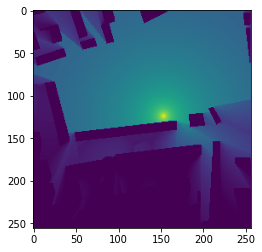

In [6]:
i=500
image_build_ant, image_gain = Radio_train[i]
plt.imshow(image_gain[0])

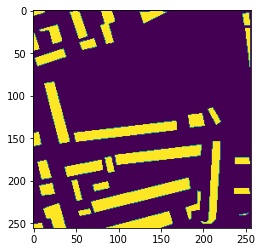

In [7]:
plt.imshow(image_build_ant[0])

## Model Building

In [8]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding, pool):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        #In conv, the dimension of the output, if the input is H,W, is
        # H+2*padding-kernel +1
        nn.ReLU(inplace=True),
        nn.MaxPool2d(pool, stride=pool, padding=0, dilation=1, return_indices=False, ceil_mode=False) 
        #pooling takes Height H and width W to (H-pool)/pool+1 = H/pool, and floor. Same for W.
        #altogether, the output size is (H+2*padding-kernel +1)/pool. 
    )

def convreluT(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride=2, padding=padding),
        nn.ReLU(inplace=True)
        #input is H X W, output is   (H-1)*2 - 2*padding + kernel
    )


    
class RadioWNet(nn.Module):

    def __init__(self,inputs=2,phase="firstU"):
        super().__init__()
        
        self.inputs=inputs
        self.phase=phase
        
        if inputs<=3:
            self.layer00 = convrelu(inputs, 6, 3, 1,1) 
            self.layer0 = convrelu(6, 40, 5, 2,2) 
        else:
            self.layer00 = convrelu(inputs, 10, 3, 1,1) 
            self.layer0 = convrelu(10, 40, 5, 2,2) 
         
        self.layer1 = convrelu(40, 50, 5, 2,2)  
        self.layer10 = convrelu(50, 60, 5, 2,1)  
        self.layer2 = convrelu(60, 100, 5, 2,2) 
        self.layer20 = convrelu(100, 100, 3, 1,1) 
        self.layer3 = convrelu(100, 150, 5, 2,2) 
        self.layer4 =convrelu(150, 300, 5, 2,2) 
        self.layer5 =convrelu(300, 500, 5, 2,2) 
        
        self.conv_up5 =convreluT(500, 300, 4, 1)  
        self.conv_up4 = convreluT(300+300, 150, 4, 1) 
        self.conv_up3 = convreluT(150 + 150, 100, 4, 1) 
        self.conv_up20 = convrelu(100 + 100, 100, 3, 1, 1) 
        self.conv_up2 = convreluT(100 + 100, 60, 6, 2) 
        self.conv_up10 = convrelu(60 + 60, 50, 5, 2, 1) 
        self.conv_up1 = convreluT(50 + 50, 40, 6, 2)
        self.conv_up0 = convreluT(40 + 40, 20, 6, 2) 
        if inputs<=3:
            self.conv_up00 = convrelu(20+6+inputs, 20, 5, 2,1)
           
        else:
            self.conv_up00 = convrelu(20+10+inputs, 20, 5, 2,1)
        
        self.conv_up000 = convrelu(20+inputs, 1, 5, 2,1)
        
        self.Wlayer00 = convrelu(inputs+1, 20, 3, 1,1) 
        self.Wlayer0 = convrelu(20, 30, 5, 2,2)  
        self.Wlayer1 = convrelu(30, 40, 5, 2,2)  
        self.Wlayer10 = convrelu(40, 50, 5, 2,1)  
        self.Wlayer2 = convrelu(50, 60, 5, 2,2) 
        self.Wlayer20 = convrelu(60, 70, 3, 1,1) 
        self.Wlayer3 = convrelu(70, 90, 5, 2,2) 
        self.Wlayer4 =convrelu(90, 110, 5, 2,2) 
        self.Wlayer5 =convrelu(110, 150, 5, 2,2) 
        
        self.Wconv_up5 =convreluT(150, 110, 4, 1)  
        self.Wconv_up4 = convreluT(110+110, 90, 4, 1) 
        self.Wconv_up3 = convreluT(90 + 90, 70, 4, 1) 
        self.Wconv_up20 = convrelu(70 + 70, 60, 3, 1, 1) 
        self.Wconv_up2 = convreluT(60 + 60, 50, 6, 2) 
        self.Wconv_up10 = convrelu(50 + 50, 40, 5, 2, 1) 
        self.Wconv_up1 = convreluT(40 + 40, 30, 6, 2)
        self.Wconv_up0 = convreluT(30 + 30, 20, 6, 2) 
        self.Wconv_up00 = convrelu(20+20+inputs+1, 20, 5, 2,1)
        self.Wconv_up000 = convrelu(20+inputs+1, 1, 5, 2,1)

    def forward(self, input):
        
        input0=input[:,0:self.inputs,:,:]
        
        if self.phase=="firstU":
            layer00 = self.layer00(input0)
            layer0 = self.layer0(layer00)
            layer1 = self.layer1(layer0)
            layer10 = self.layer10(layer1)
            layer2 = self.layer2(layer10)
            layer20 = self.layer20(layer2)
            layer3 = self.layer3(layer20)
            layer4 = self.layer4(layer3)
            layer5 = self.layer5(layer4)
        
            layer4u = self.conv_up5(layer5)
            layer4u = torch.cat([layer4u, layer4], dim=1)
            layer3u = self.conv_up4(layer4u)
            layer3u = torch.cat([layer3u, layer3], dim=1)
            layer20u = self.conv_up3(layer3u)
            layer20u = torch.cat([layer20u, layer20], dim=1)
            layer2u = self.conv_up20(layer20u)
            layer2u = torch.cat([layer2u, layer2], dim=1)
            layer10u = self.conv_up2(layer2u)
            layer10u = torch.cat([layer10u, layer10], dim=1)
            layer1u = self.conv_up10(layer10u)
            layer1u = torch.cat([layer1u, layer1], dim=1)
            layer0u = self.conv_up1(layer1u)
            layer0u = torch.cat([layer0u, layer0], dim=1)
            layer00u = self.conv_up0(layer0u)
            layer00u = torch.cat([layer00u, layer00], dim=1)
            layer00u = torch.cat([layer00u,input0], dim=1)
            layer000u  = self.conv_up00(layer00u)
            layer000u = torch.cat([layer000u,input0], dim=1)
            output1  = self.conv_up000(layer000u)
        
            Winput=torch.cat([output1, input], dim=1).detach()
        
            Wlayer00 = self.Wlayer00(Winput).detach()
            Wlayer0 = self.Wlayer0(Wlayer00).detach()
            Wlayer1 = self.Wlayer1(Wlayer0).detach()
            Wlayer10 = self.Wlayer10(Wlayer1).detach()
            Wlayer2 = self.Wlayer2(Wlayer10).detach()
            Wlayer20 = self.Wlayer20(Wlayer2).detach()
            Wlayer3 = self.Wlayer3(Wlayer20).detach()
            Wlayer4 = self.Wlayer4(Wlayer3).detach()
            Wlayer5 = self.Wlayer5(Wlayer4).detach()
        
            Wlayer4u = self.Wconv_up5(Wlayer5).detach()
            Wlayer4u = torch.cat([Wlayer4u, Wlayer4], dim=1).detach()
            Wlayer3u = self.Wconv_up4(Wlayer4u).detach()
            Wlayer3u = torch.cat([Wlayer3u, Wlayer3], dim=1).detach()
            Wlayer20u = self.Wconv_up3(Wlayer3u).detach()
            Wlayer20u = torch.cat([Wlayer20u, Wlayer20], dim=1).detach()
            Wlayer2u = self.Wconv_up20(Wlayer20u).detach()
            Wlayer2u = torch.cat([Wlayer2u, Wlayer2], dim=1).detach()
            Wlayer10u = self.Wconv_up2(Wlayer2u).detach()
            Wlayer10u = torch.cat([Wlayer10u, Wlayer10], dim=1).detach()
            Wlayer1u = self.Wconv_up10(Wlayer10u).detach()
            Wlayer1u = torch.cat([Wlayer1u, Wlayer1], dim=1).detach()
            Wlayer0u = self.Wconv_up1(Wlayer1u).detach()
            Wlayer0u = torch.cat([Wlayer0u, Wlayer0], dim=1).detach()
            Wlayer00u = self.Wconv_up0(Wlayer0u).detach()
            Wlayer00u = torch.cat([Wlayer00u, Wlayer00], dim=1).detach()
            Wlayer00u = torch.cat([Wlayer00u,Winput], dim=1).detach()
            Wlayer000u  = self.Wconv_up00(Wlayer00u).detach()
            Wlayer000u = torch.cat([Wlayer000u,Winput], dim=1).detach()
            output2  = self.Wconv_up000(Wlayer000u).detach()
            
        else:
            layer00 = self.layer00(input0).detach()
            layer0 = self.layer0(layer00).detach()
            layer1 = self.layer1(layer0).detach()
            layer10 = self.layer10(layer1).detach()
            layer2 = self.layer2(layer10).detach()
            layer20 = self.layer20(layer2).detach()
            layer3 = self.layer3(layer20).detach()
            layer4 = self.layer4(layer3).detach()
            layer5 = self.layer5(layer4).detach()
        
            layer4u = self.conv_up5(layer5).detach()
            layer4u = torch.cat([layer4u, layer4], dim=1).detach()
            layer3u = self.conv_up4(layer4u).detach()
            layer3u = torch.cat([layer3u, layer3], dim=1).detach()
            layer20u = self.conv_up3(layer3u).detach()
            layer20u = torch.cat([layer20u, layer20], dim=1).detach()
            layer2u = self.conv_up20(layer20u).detach()
            layer2u = torch.cat([layer2u, layer2], dim=1).detach()
            layer10u = self.conv_up2(layer2u).detach()
            layer10u = torch.cat([layer10u, layer10], dim=1).detach()
            layer1u = self.conv_up10(layer10u).detach()
            layer1u = torch.cat([layer1u, layer1], dim=1).detach()
            layer0u = self.conv_up1(layer1u).detach()
            layer0u = torch.cat([layer0u, layer0], dim=1).detach()
            layer00u = self.conv_up0(layer0u).detach()
            layer00u = torch.cat([layer00u, layer00], dim=1).detach()
            layer00u = torch.cat([layer00u,input0], dim=1).detach()
            layer000u  = self.conv_up00(layer00u).detach()
            layer000u = torch.cat([layer000u,input0], dim=1).detach()
            output1  = self.conv_up000(layer000u).detach()
        
            Winput=torch.cat([output1, input], dim=1).detach()
        
            Wlayer00 = self.Wlayer00(Winput)
            Wlayer0 = self.Wlayer0(Wlayer00)
            Wlayer1 = self.Wlayer1(Wlayer0)
            Wlayer10 = self.Wlayer10(Wlayer1)
            Wlayer2 = self.Wlayer2(Wlayer10)
            Wlayer20 = self.Wlayer20(Wlayer2)
            Wlayer3 = self.Wlayer3(Wlayer20)
            Wlayer4 = self.Wlayer4(Wlayer3)
            Wlayer5 = self.Wlayer5(Wlayer4)
        
            Wlayer4u = self.Wconv_up5(Wlayer5)
            Wlayer4u = torch.cat([Wlayer4u, Wlayer4], dim=1)
            Wlayer3u = self.Wconv_up4(Wlayer4u)
            Wlayer3u = torch.cat([Wlayer3u, Wlayer3], dim=1)
            Wlayer20u = self.Wconv_up3(Wlayer3u)
            Wlayer20u = torch.cat([Wlayer20u, Wlayer20], dim=1)
            Wlayer2u = self.Wconv_up20(Wlayer20u)
            Wlayer2u = torch.cat([Wlayer2u, Wlayer2], dim=1)
            Wlayer10u = self.Wconv_up2(Wlayer2u)
            Wlayer10u = torch.cat([Wlayer10u, Wlayer10], dim=1)
            Wlayer1u = self.Wconv_up10(Wlayer10u)
            Wlayer1u = torch.cat([Wlayer1u, Wlayer1], dim=1)
            Wlayer0u = self.Wconv_up1(Wlayer1u)
            Wlayer0u = torch.cat([Wlayer0u, Wlayer0], dim=1)
            Wlayer00u = self.Wconv_up0(Wlayer0u)
            Wlayer00u = torch.cat([Wlayer00u, Wlayer00], dim=1)
            Wlayer00u = torch.cat([Wlayer00u,Winput], dim=1)
            Wlayer000u  = self.Wconv_up00(Wlayer00u)
            Wlayer000u = torch.cat([Wlayer000u,Winput], dim=1)
            output2  = self.Wconv_up000(Wlayer000u)
        
        return [output1,output2]
    
    
    
    
    
  

In [9]:
from torchsummary import summary
import torch

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model =RadioWNet(phase="firstU")
summary(model, input_size=(2, 256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             114
              ReLU-2          [-1, 6, 256, 256]               0
         MaxPool2d-3          [-1, 6, 256, 256]               0
            Conv2d-4         [-1, 40, 256, 256]           6,040
              ReLU-5         [-1, 40, 256, 256]               0
         MaxPool2d-6         [-1, 40, 128, 128]               0
            Conv2d-7         [-1, 50, 128, 128]          50,050
              ReLU-8         [-1, 50, 128, 128]               0
         MaxPool2d-9           [-1, 50, 64, 64]               0
           Conv2d-10           [-1, 60, 64, 64]          75,060
             ReLU-11           [-1, 60, 64, 64]               0
        MaxPool2d-12           [-1, 60, 64, 64]               0
           Conv2d-13          [-1, 100, 64, 64]         150,100
             ReLU-14          [-1, 100,

In [10]:
!pip install tqdm

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

def calc_loss_dense(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def calc_loss_sparse(pred, target, samples, metrics, num_samples):
    criterion = nn.MSELoss()
    loss = criterion(samples*pred, samples*target)*(256**2)/num_samples
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs1 = []
    outputs2 = []
    for k in metrics.keys():
        outputs1.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs1)))

def train_model(model, optimizer, scheduler, num_epochs=5, WNetPhase="firstU", targetType="dense", num_samples=300):
    # WNetPhase: traine first U and freez second ("firstU"), or vice verse ("secondU").
    # targetType: train against dense images ("dense") or sparse measurements ("sparse")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            if targetType=="dense":
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_dense(outputs1, targets, metrics)
                        else:
                            loss = calc_loss_dense(outputs2, targets, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)
            elif targetType=="sparse":
                for inputs, targets, samples in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    samples = samples.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1,outputs2] = model(inputs)
                        if WNetPhase=="firstU":
                            loss = calc_loss_sparse(outputs1, targets, samples, metrics, num_samples)
                        else:
                            loss = calc_loss_sparse(outputs2, targets, samples, metrics, num_samples)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler)

## Student Network

In [14]:
teacher_model =RadioWNet(phase="secondU")
teacher_model.load_state_dict(torch.load('/content/Trained_Model_SecondU.pt'))
teacher_model.to(device) 

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(6, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class STUNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[16, 32, 64, 128],
    ):
        super(STUNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 2, 256, 256))
    model = STUNET(in_channels=2, out_channels=1)
    preds = model(x)
    print("Prediction shape: ", preds.shape)
    print("Image shape: ", x.shape)
    # assert preds.shape == x.shape

# if __name__ == "__main__":
#     test()

In [16]:
test()


Prediction shape:  torch.Size([3, 1, 256, 256])
Image shape:  torch.Size([3, 2, 256, 256])


In [17]:
student_model = STUNET(in_channels=2, out_channels=1)

## Knowledge Distillation

In [18]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
from tqdm import tqdm

In [39]:
class SegmentationLoss:
    def __init__(self):
        pass

    def MSE_loss(self, predictions, targets, metrics):
        criterion = nn.MSELoss()
        loss = criterion(predictions, targets)
        metrics['soft_target_loss'] += loss.data.cpu().numpy() * targets.size(0)
        return loss

    def dice_loss(self, pred, target, smooth=1.0):
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=2).sum(dim=2)
        smooth = torch.tensor([[smooth]])

        d_loss = (1 - ((2. * intersection + smooth) / (
                    pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

        return d_loss.mean()

    def bce_loss(self, predictions, targets, metrics):
        criterion = nn.BCELoss()
        loss = criterion(predictions, targets)
        # metrics['bce_loss'] += loss.data.cpu().numpy() * targets.size(0)
        return loss


class KnowledgeDistiller(nn.Module):
    def __init__(self, teacher_model,
                 student_model,
                 hard_prediction_loss_fn,
                 soft_prediction_loss_fn,
                 alpha=0.5):

        super(KnowledgeDistiller, self).__init__()
        self.teacher = teacher_model
        self.student = student_model
        self.hard_loss_fn = hard_prediction_loss_fn
        self.soft_loss_fn = soft_prediction_loss_fn
        self.alpha = alpha

    def train_model(self, optimizer, scheduler, num_epochs, device, save_model=False):
        global metrics
        best_model_wts = copy.deepcopy(self.student.state_dict())
        best_loss = 1e10
        epoch_loss_list = []

        for epoch in tqdm((range(num_epochs))):
            since = time.time()
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    for param_group in optimizer.param_groups:
                        print("learning rate", param_group['lr'])
                    self.student.train()
                else:
                    self.student.eval()

                metrics = defaultdict(float)
                epoch_samples = 0
                img_index = 0
                for inputs, targets in tqdm(dataloaders[phase]):
                    # if phase == 'train':
                    #     print("Training for Image: ", img_index+1)
                    # else:
                    #     print("Validating for: ", img_index + 1)
                    img_index += 1
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    ## Zero the gradients
                    optimizer.zero_grad()

                    ## Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        [soft_outputs_1, soft_outputs_2] = self.teacher(inputs)
                        predictions = self.student(inputs)
                        hard_target_loss = self.hard_loss_fn(predictions, targets, metrics)
                        # soft_outputs_1.requires_grad = False
                        soft_target_loss = self.soft_loss_fn(predictions, soft_outputs_1, metrics)
                        loss = self.alpha * hard_target_loss + (1 - self.alpha) * soft_target_loss
                        metrics['loss'] += loss.data.cpu().numpy() * targets.size(0)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    epoch_samples += inputs.size(0)

                    epoch_loss = metrics['loss'] / epoch_samples
                    epoch_loss_list.append(epoch_loss)

                    if phase == 'val' and epoch_loss < best_loss:
                        print("saving best model")
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(self.student.state_dict())

                time_elapsed = time.time() - since
                print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        print('Best val loss: {:4f}'.format(best_loss))

        # load best model weights
        self.student.load_state_dict(best_model_wts)
        if save_model:
            # version = int(input("Enter the version number: "))
            base_path = r'/content/'
            save_path = base_path + 'Student_model_' + str(2) + '.pt'
            torch.save(self.student.state_dict(), save_path)
        return self.student, metrics, epoch_loss_list

In [40]:
loss_obj = SegmentationLoss()
student_model.to(device)
kn = KnowledgeDistiller(teacher_model=teacher_model, student_model=student_model,
                        hard_prediction_loss_fn=loss_obj.MSE_loss,
                        soft_prediction_loss_fn=loss_obj.MSE_loss)

In [41]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, student_model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
trained_student_model, metrics, epoch_loss = kn.train_model(optimizer_ft, exp_lr_scheduler, 4, device)

In [ ]:
trained_student_model.state_dict()

In [47]:
version = int(input("Enter the version number: "))
base_path = r'/content/'
save_path = base_path + 'Student_model_' + str(version) + '.pt'
torch.save(trained_student_model.state_dict(), save_path)

Enter the version number: 2


In [48]:
metrics

defaultdict(float,
            {'loss': 24.722218883689493,
             'soft_target_loss': 49.44443770800717})

In [50]:
len(epoch_loss)

12824

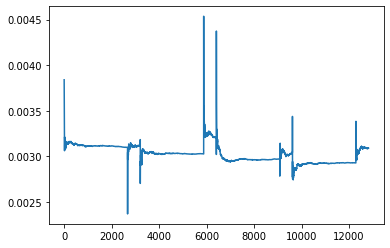

In [51]:
plt.plot(epoch_loss)
plt.show()

In [52]:
len(epoch_loss)/4

3206.0

## Test Accuracy

In [53]:
print("Length of the test set : ", len(Radio_test))

Length of the test set :  7920


In [54]:
test_loader = DataLoader(Radio_test, batch_size=1, shuffle=True, num_workers=1)

In [55]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

def calc_loss_test(pred1, pred2, target, metrics, error="MSE"):
    criterion = nn.MSELoss()
    if error=="MSE":
        loss1 = criterion(pred1, target)
        loss2 = criterion(pred2, target)
    else:
        loss1 = criterion(pred1, target)/criterion(target, 0*target)
        loss2 = criterion(pred2, target)/criterion(target, 0*target)
    metrics['Teacher loss'] += loss1.data.cpu().numpy() * target.size(0)
    metrics['Student loss'] += loss2.data.cpu().numpy() * target.size(0)

    return [loss1,loss2]

def print_metrics_test(metrics, epoch_samples, error):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format("Test"+" "+error, ", ".join(outputs)))

def test_loss(student_model, teacher_model, error="MSE", dataset="coarse"):
    # dataset is "coarse" or "fine".
    since = time.time()
    teacher_model.eval()   # Set teacher model to evaluate mode
    student_model.eval()   # Set student model to evaluate mode
    metrics = defaultdict(float)
    epoch_samples = 0
    if dataset=="coarse":
        for inputs, targets in tqdm(DataLoader(Radio_test, batch_size=5, shuffle=True, num_workers=1)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [pred_1, _] = teacher_model(inputs)
                pred_2 = student_model(inputs)
                [loss1,loss2] = calc_loss_test(pred_1, pred_2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    elif dataset=="fine":  
        for inputs, targets, samples in DataLoader(Radio_test, batch_size=batch_size, shuffle=True, num_workers=1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # do not track history if only in train
            with torch.set_grad_enabled(False):
                [outputs1,outputs2] = model(inputs)
                [loss1,loss2] = calc_loss_test(outputs1, outputs2, targets, metrics, error)
                epoch_samples += inputs.size(0)
    print_metrics_test(metrics, epoch_samples, error)
    #test_loss1 = metrics['loss U'] / epoch_samples
    #test_loss2 = metrics['loss W'] / epoch_samples
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [56]:
test_loss(trained_student_model, teacher_model)




  0%|          | 0/1584 [00:00<?, ?it/s]


  0%|          | 1/1584 [00:00<04:07,  6.40it/s]


  0%|          | 3/1584 [00:00<03:29,  7.54it/s]


  0%|          | 5/1584 [00:00<03:00,  8.74it/s]


  0%|          | 7/1584 [00:00<02:39,  9.90it/s]


  1%|          | 9/1584 [00:00<02:24, 10.89it/s]


  1%|          | 11/1584 [00:00<02:15, 11.65it/s]


  1%|          | 13/1584 [00:01<02:07, 12.35it/s]


  1%|          | 15/1584 [00:01<02:01, 12.87it/s]


  1%|          | 17/1584 [00:01<01:58, 13.27it/s]


  1%|          | 19/1584 [00:01<01:55, 13.55it/s]


  1%|▏         | 21/1584 [00:01<01:53, 13.77it/s]


  1%|▏         | 23/1584 [00:01<01:52, 13.91it/s]


  2%|▏         | 25/1584 [00:01<01:51, 14.02it/s]


  2%|▏         | 27/1584 [00:01<01:50, 14.09it/s]


  2%|▏         | 29/1584 [00:02<01:50, 14.10it/s]


  2%|▏         | 31/1584 [00:02<01:50, 14.04it/s]


  2%|▏         | 33/1584 [00:02<01:50, 13.98it/s]


  2%|▏         | 35/1584 [00:02<01:50, 13.96it/s]


  2%|▏         | 37/158

Test MSE: Teacher loss: 0.000463, Student loss: 0.003363
1m 54s


In [57]:
0.003363/0.000463

7.263498920086394